In [1]:
import torch, pickle, scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

from pathlib import Path
import sys, os

script_dir = Path().resolve()
sys.path.append(str(script_dir))
dann_dir = script_dir / 'dann'
sys.path.append(str(dann_dir))
print(script_dir)


# now regular import works
from lightning_dann import DANNModule
from cdan import CDANModule
from transformer_dann import TransformerDANNModule


# from lightning_dann import DANNModule
import numpy as np

import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 600
plt.rcParams["figure.figsize"] = (12, 8)

/oscar/data/rsingh47/wli115/universalgene/src


In [2]:
data_dir = script_dir / 'data'
sys.path.append(str(data_dir))

tm_adata_dir = data_dir / 'tabula_muris' / 'preprocessed' 

# tm_adata_path = r'../data/tabula_muris/preprocessed/tm_adata_all.pkl'
# tm_adata_path = r'../data/tabula_muris/preprocessed/tm_adata_test.pkl'
tm_adata_test_path = tm_adata_dir /'tm_adata_test.pkl'
with open(tm_adata_test_path, 'rb') as f:
    tm_adata_test = pickle.load(f)

tm_adata_train_path = tm_adata_dir /'tm_adata_train.pkl'
with open(tm_adata_train_path, 'rb') as f:
    tm_adata_train = pickle.load(f)

In [3]:
# model = DANNModule.load_from_checkpoint("checkpoints/dann_full.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_full_epochs100.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_train_tissue_epochs100.ckpt")
# model = DANNModule.load_from_checkpoint("checkpoints/dann_train_tissue_epochs500.ckpt") # linear encoder
# dann_model = DANNModule.load_from_checkpoint("dann/checkpoints/dann-epochs100-batch_size128-FINAL/val_loss1.102.ckpt") # modified transformer weird dann
dann_model = DANNModule.load_from_checkpoint("dann/checkpoints/dann-epochs100-batch_size128-FINAL-REVERTED/val_loss1.030.ckpt") 
cdan_model = CDANModule.load_from_checkpoint("dann/checkpoints/cdan-epochs100-batch_size128-FINAL/val_loss0.889.ckpt")
transformer_dann_model = TransformerDANNModule.load_from_checkpoint("dann/checkpoints/transformer_dann-epochs100-batch_size128-FINAL/val_loss0.947.ckpt")

dann_encoder = dann_model.encoder
dann_encoder.eval()

cdan_encoder = cdan_model.encoder
cdan_encoder.eval()

transformer_encoder = transformer_dann_model.encoder
transformer_encoder.eval()

TransformerEncoder(
  (proj): Linear(in_features=2000, out_features=512, bias=True)
  (tf): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (out): Linear(in_features=512, out_features=128, bias=True)
)

In [4]:
X = tm_adata_test.X.toarray()
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
with torch.no_grad():
    dann_embeddings = dann_encoder(X_tensor).cpu().numpy()
    cdan_embeddings = cdan_encoder(X_tensor).cpu().numpy()
    transformer_embeddings = transformer_encoder(X_tensor).cpu().numpy()

In [5]:
DANN_KEY = 'X_latent_dann'
CDAN_KEY = 'X_latent_cdan'
TRANSFORMER_KEY = 'X_latent_transformer'
tm_adata_test.obsm[DANN_KEY] = dann_embeddings
tm_adata_test.obsm[CDAN_KEY] = cdan_embeddings
tm_adata_test.obsm[TRANSFORMER_KEY] = transformer_embeddings

/tmp/ipykernel_392337/1112256813.py:4: ImplicitModificationWarning: Setting element `.obsm['X_latent_dann']` of view, initializing view as actual.
  tm_adata_test.obsm[DANN_KEY] = dann_embeddings


In [7]:
# sc.pp.neighbors(tm_adata_test, use_rep=DANN_KEY)  # Compute neighbors using latent space
# sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/DANN'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


In [8]:
sc.pp.neighbors(tm_adata_test, use_rep=CDAN_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/CDAN'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


In [9]:
sc.pp.neighbors(tm_adata_test, use_rep=TRANSFORMER_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/TRANSFORMER_DANN'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


#### scVI

##### transfer

In [10]:
import scvi

In [11]:
tm_adata_train.layers["counts"] = tm_adata_train.X.copy()
scvi.model.SCVI.setup_anndata(tm_adata_train, layer="counts", batch_key="tech")


scvi_model = scvi.model.SCVI(tm_adata_train)
scvi_model.train()


/tmp/ipykernel_392337/3395867084.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  tm_adata_train.layers["counts"] = tm_adata_train.X.copy()
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_mat

Epoch 1/27:   0%|                                                                                                    | 0/27 [00:00<?, ?it/s]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/27:   4%|█▍                                      | 1/27 [00:16<07:14, 16.69s/it, v_num=1, train_loss_step=175, train_loss_epoch=202]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 3/27:   7%|██▉                                     | 2/27 [00:33<06:54, 16.57s/it, v_num=1, train_loss_step=171, train_loss_epoch=181]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 4/27:  11%|████▍                                   | 3/27 [00:49<06:39, 16.63s/it, v_num=1, train_loss_step=182, train_loss_epoch=176]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 5/27:  15%|█████▉                                  | 4/27 [01:06<06:21, 16.57s/it, v_num=1, train_loss_step=185, train_loss_epoch=174]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 6/27:  19%|███████▍                                | 5/27 [01:23<06:06, 16.68s/it, v_num=1, train_loss_step=184, train_loss_epoch=173]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 7/27:  22%|████████▉                               | 6/27 [01:40<05:53, 16.82s/it, v_num=1, train_loss_step=182, train_loss_epoch=172]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 8/27:  26%|██████████▎                             | 7/27 [01:56<05:34, 16.72s/it, v_num=1, train_loss_step=170, train_loss_epoch=172]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 9/27:  30%|███████████▊                            | 8/27 [02:13<05:16, 16.64s/it, v_num=1, train_loss_step=152, train_loss_epoch=171]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/27:  33%|█████████████                          | 9/27 [02:29<04:58, 16.59s/it, v_num=1, train_loss_step=181, train_loss_epoch=171]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 11/27:  37%|██████████████                        | 10/27 [02:46<04:41, 16.56s/it, v_num=1, train_loss_step=181, train_loss_epoch=171]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 12/27:  41%|███████████████▍                      | 11/27 [03:03<04:25, 16.62s/it, v_num=1, train_loss_step=170, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 13/27:  44%|████████████████▉                     | 12/27 [03:19<04:08, 16.58s/it, v_num=1, train_loss_step=172, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 14/27:  48%|██████████████████▎                   | 13/27 [03:36<03:51, 16.57s/it, v_num=1, train_loss_step=184, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 15/27:  52%|███████████████████▋                  | 14/27 [03:52<03:34, 16.53s/it, v_num=1, train_loss_step=154, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 16/27:  56%|█████████████████████                 | 15/27 [04:09<03:19, 16.66s/it, v_num=1, train_loss_step=168, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 17/27:  59%|██████████████████████▌               | 16/27 [04:26<03:05, 16.83s/it, v_num=1, train_loss_step=143, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 18/27:  63%|███████████████████████▉              | 17/27 [04:43<02:47, 16.74s/it, v_num=1, train_loss_step=164, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 19/27:  67%|█████████████████████████▎            | 18/27 [04:59<02:30, 16.68s/it, v_num=1, train_loss_step=166, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 20/27:  70%|██████████████████████████▋           | 19/27 [05:16<02:13, 16.65s/it, v_num=1, train_loss_step=181, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 21/27:  74%|████████████████████████████▏         | 20/27 [05:33<01:57, 16.75s/it, v_num=1, train_loss_step=189, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 22/27:  78%|█████████████████████████████▌        | 21/27 [05:50<01:40, 16.75s/it, v_num=1, train_loss_step=198, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 23/27:  81%|██████████████████████████████▉       | 22/27 [06:07<01:24, 16.84s/it, v_num=1, train_loss_step=177, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 24/27:  85%|████████████████████████████████▎     | 23/27 [06:23<01:07, 16.78s/it, v_num=1, train_loss_step=167, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 25/27:  89%|█████████████████████████████████▊    | 24/27 [06:40<00:50, 16.77s/it, v_num=1, train_loss_step=177, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 26/27:  93%|███████████████████████████████████▏  | 25/27 [06:57<00:33, 16.72s/it, v_num=1, train_loss_step=174, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/27:  96%|████████████████████████████████████▌ | 26/27 [07:14<00:16, 16.85s/it, v_num=1, train_loss_step=158, train_loss_epoch=170]

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scvi/module/_vae.py:460: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 27/27: 100%|██████████████████████████████████████| 27/27 [07:31<00:00, 16.94s/it, v_num=1, train_loss_step=174, train_loss_epoch=170]

`Trainer.fit` stopped: `max_epochs=27` reached.


Epoch 27/27: 100%|██████████████████████████████████████| 27/27 [07:31<00:00, 16.72s/it, v_num=1, train_loss_step=174, train_loss_epoch=170]


In [12]:
SCVI_TRANSFER_KEY = "X_latent_scvi_transfer"
tm_adata_test.obsm[SCVI_TRANSFER_KEY] = scvi_model.get_latent_representation(tm_adata_test)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [13]:
sc.pp.neighbors(tm_adata_test, use_rep=SCVI_TRANSFER_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/SCVI_TRANSFER'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


##### scvi cheat

In [14]:
scvi.model.SCVI.setup_anndata(tm_adata_test, layer="counts", batch_key="tech")
scvi_model_cheat = scvi.model.SCVI(tm_adata_test)
scvi_model_cheat.train()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 130/130: 100%|██████████████████████████████████| 130/130 [06:54<00:00,  3.17s/it, v_num=1, train_loss_step=560, train_loss_epoch=490]

`Trainer.fit` stopped: `max_epochs=130` reached.


Epoch 130/130: 100%|██████████████████████████████████| 130/130 [06:54<00:00,  3.19s/it, v_num=1, train_loss_step=560, train_loss_epoch=490]


In [15]:
SCVI_CHEAT_KEY = "X_latent_scvi_cheat"
tm_adata_test.obsm[SCVI_CHEAT_KEY] = scvi_model_cheat.get_latent_representation()

In [16]:
sc.pp.neighbors(tm_adata_test, use_rep=SCVI_CHEAT_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/SCVI_CHEAT'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


#### PCA

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
n_clusters = len(tm_adata_test.obs["cell_ontology_class"].unique())

PCA_KEY = 'X_pca'

sc.tl.pca(tm_adata_test)
# Apply K-Means clustering on PCA embeddings
sc.pp.neighbors(tm_adata_test, use_rep=PCA_KEY)

In [18]:
# sc.pp.neighbors(tm_adata_test, use_rep=PCA_KEY)  # Compute neighbors using latent space
sc.tl.umap(tm_adata_test)  # Run UMAP

print('finished computing UMAP')

output_folder = r'./figures/final/PCA'
os.makedirs(output_folder, exist_ok=True)
fig = sc.pl.umap(tm_adata_test, color='cell_ontology_class', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_celltypes.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='tech', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_tech.png')
plt.close(fig)

fig = sc.pl.umap(tm_adata_test, color='celltype_tech_availability', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
fig.savefig(f'{output_folder}/test_availability.png')
plt.close(fig)

finished computing UMAP


#### scIB Benchmarks

In [19]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    tm_adata_test,
    batch_key='tech',
    label_key='cell_ontology_class',
    embedding_obsm_keys=[SCVI_TRANSFER_KEY, SCVI_CHEAT_KEY, DANN_KEY, CDAN_KEY, TRANSFORMER_KEY, PCA_KEY],
    n_jobs=-1
)
bm.benchmark()

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|                                                                                                     | 0/6 [00:00<?, ?it/s]2025-05-08 21:56:22.612269: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages

INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  17%|███████████████▌                                                                             | 1/6 [00:59<04:59, 59.81s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|███████████████████████████████                                                              | 2/6 [01:41<03:15, 48.97s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  50%|██████████████████████████████████████████████▌                                              | 3/6 [02:33<02:32, 50.72s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  67%|██████████████████████████████████████████████████████████████                               | 4/6 [03:26<01:42, 51.30s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  83%|█████████████████████████████████████████████████████████████████████████████▌               | 5/6 [04:13<00:49, 49.76s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:54<00:00, 49.03s/it]


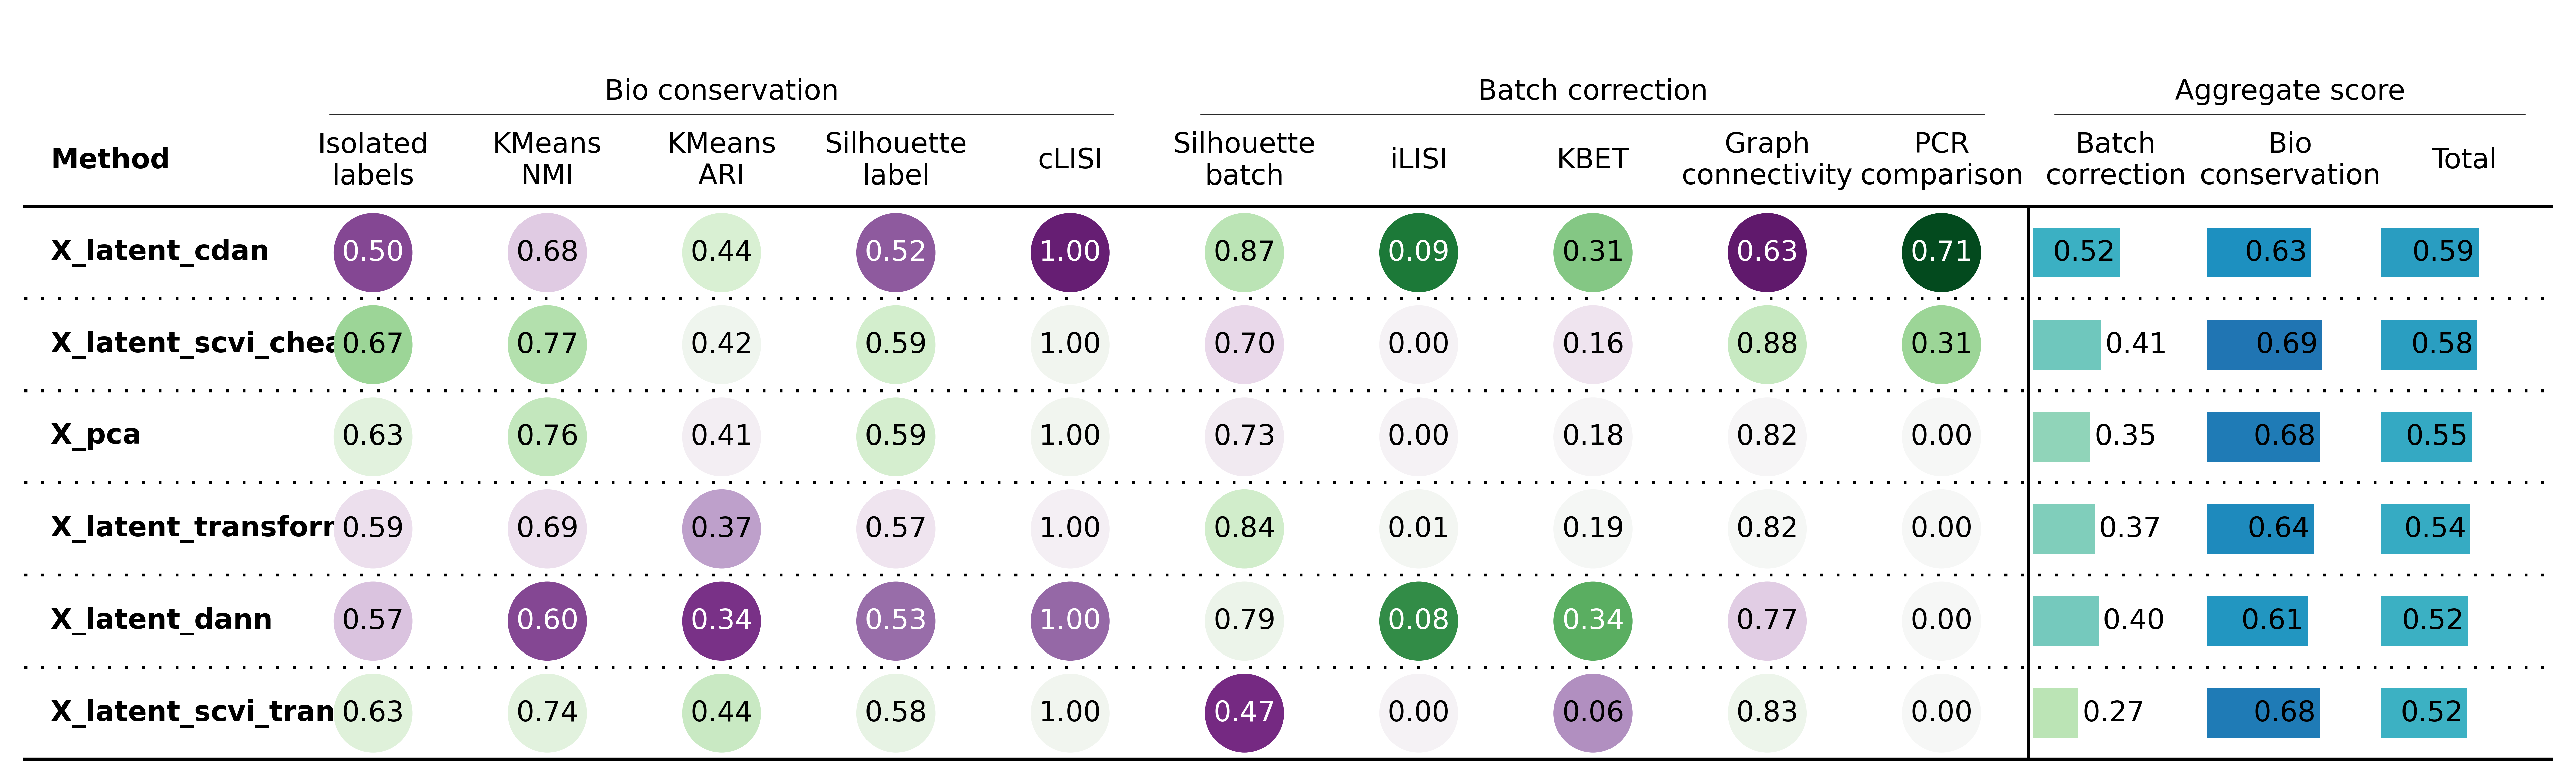

In [20]:
bm.plot_results_table(min_max_scale=False)